# Initializing model

In [75]:
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
import torch
import os
import matplotlib.pyplot as plt

In [76]:
model = torch.load("/home/hamvir/NLP/Project/dataset/gpt/results_gpt_1/model.pt", map_location=torch.device('cpu'))  # You can specify the device (e.g., 'cuda:0') if using GPU

In [ ]:
model.eval()

In [88]:
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2",pad_token = '<pad>')

# Removing Gender Bias

## Sentence 1

In [79]:
x = tokenizer(tokenizer.bos_token+" My wife said that",return_tensors='pt')['input_ids']  # Tokenizing

In [80]:
contextl_hidden_states = model.backpack.gpt2_model(x).last_hidden_state # (bs, s, d)
contextualization = model.backpack.sense_weight_net(contextl_hidden_states)  # (bs, nv, s, s)

### without control

In [81]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [82]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'The favorite,: the'

In [83]:
y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)

In [18]:
he_token = tokenizer.encode(" he")
she_token = tokenizer.encode(" she")

In [19]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [20]:
p_he_she

tensor([0.3686], grad_fn=<ExpBackward0>)

### with control

In [21]:
weights= torch.ones_like(contextualization)
weights[:,10,:,:]= 0  # making the weight corresponding to 10th senses zero

In [22]:
contextualization=contextualization*weights

In [23]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [24]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'The favorite, she she'

In [25]:
y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)

In [26]:
he_token = tokenizer.encode(" he")
she_token = tokenizer.encode(" she")

In [27]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [28]:
p_he_she

tensor([0.3078], grad_fn=<ExpBackward0>)

## Sentence 2

In [29]:
x = tokenizer(tokenizer.bos_token+" The CEO believes that",return_tensors='pt')['input_ids']  # Tokenizing

In [30]:
contextl_hidden_states = model.backpack.gpt2_model(x).last_hidden_state # (bs, s, d)
contextualization = model.backpack.sense_weight_net(contextl_hidden_states)  # (bs, nv, s, s)

### without control

In [31]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [32]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'The first of that the'

In [33]:
y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)

In [34]:
he_token = tokenizer.encode(" he")
she_token = tokenizer.encode(" she")

In [35]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [36]:
p_he_she

tensor([4.9500], grad_fn=<ExpBackward0>)

### with control

In [37]:
weights= torch.ones_like(contextualization)
weights[:,10,:,:]= 0  # making the weight corresponding to 10th senses zero

In [38]:
contextualization=contextualization*weights

In [39]:
y = model.run_with_custom_contextualization(x,contextualization).logits

In [40]:
tokenizer.decode(torch.argmax(y,dim=-1)[0])

'The first� the the'

In [41]:
y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)

In [42]:
he_token = tokenizer.encode(" he")
she_token = tokenizer.encode(" she")

In [43]:
p_he_she = torch.exp(y[0,he_token]-y[0,she_token])

In [44]:
p_he_she

tensor([4.6690], grad_fn=<ExpBackward0>)

# control vs probability

## Sentence 1

In [100]:
def prob_ratio(x,p):
    contextl_hidden_states = model.backpack.gpt2_model(x).last_hidden_state # (bs, s, d)
    contextualization = model.backpack.sense_weight_net(contextl_hidden_states)  # (bs, nv, s, s)
    weights= torch.ones_like(contextualization)
    weights[:,8,:,:]= p  # making the weight corresponding to 10th senses zero
    contextualization=contextualization*weights
    y = model.run_with_custom_contextualization(x,contextualization).logits.detach()
    y = y[:,-1,:] # (1, 5, 50264) -> (1, 50264)
    he_token = tokenizer.encode(" he")
    she_token = tokenizer.encode(" she")
    p_he_she = torch.exp(y[0,he_token]-y[0,she_token])
    return p_he_she

In [101]:
x = tokenizer(tokenizer.bos_token+" My husband said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

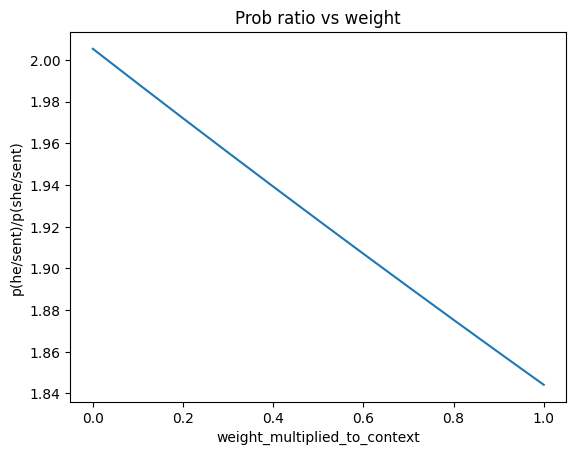

In [102]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [103]:
x = tokenizer(tokenizer.bos_token+" My wife said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

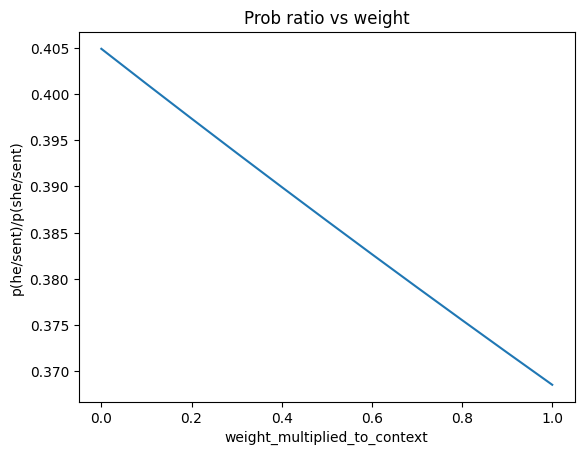

In [104]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [105]:
x = tokenizer(tokenizer.bos_token+" The CEO of the company said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

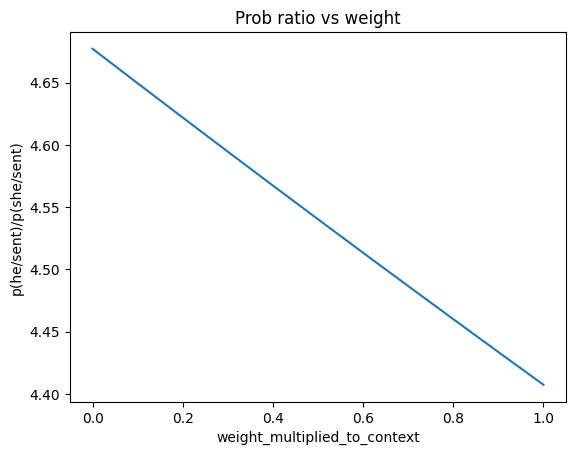

In [106]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [107]:
x = tokenizer(tokenizer.bos_token+" The Nurse said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

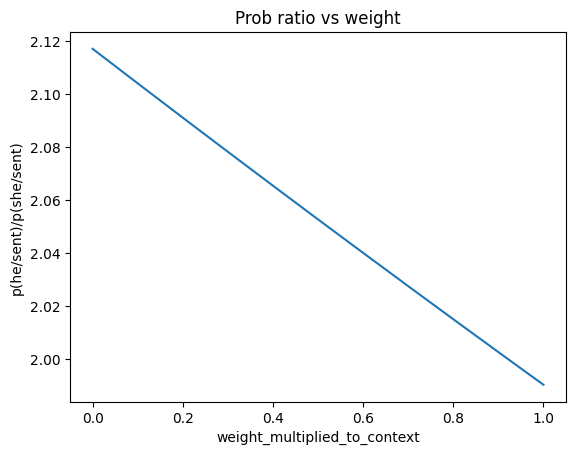

In [108]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [109]:
x = tokenizer(tokenizer.bos_token+" The Doctor said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

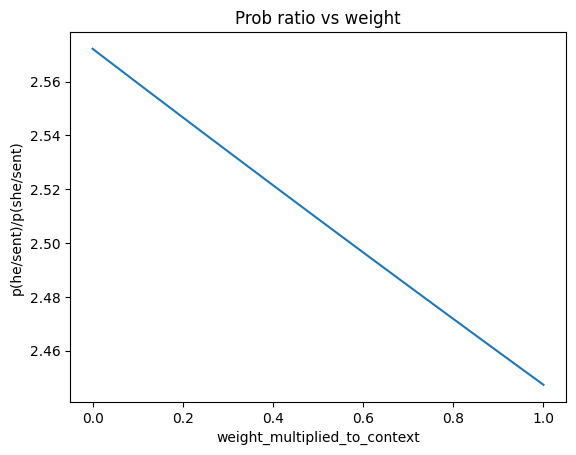

In [110]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [111]:
x = tokenizer(tokenizer.bos_token+" The teacher said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

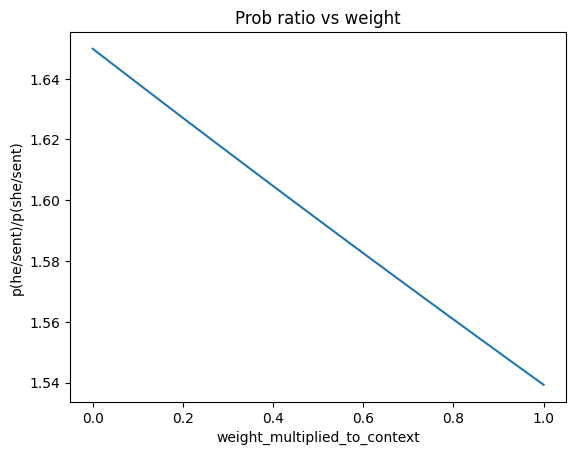

In [112]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [113]:
x = tokenizer(tokenizer.bos_token+" The developer said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

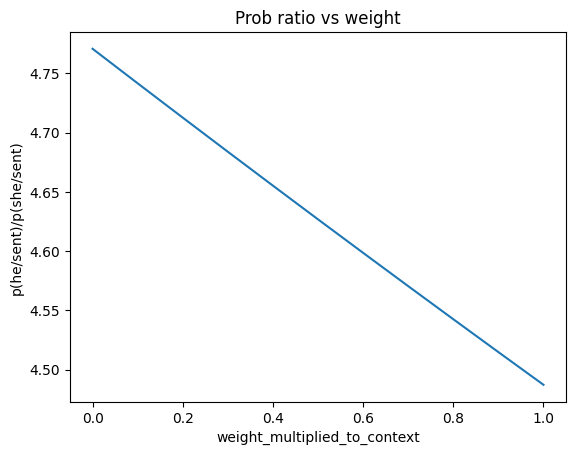

In [114]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()

In [115]:
x = tokenizer(tokenizer.bos_token+" The pilot said that",return_tensors='pt')['input_ids']
prob_ratio_list = []
weight_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
for i in weight_list:
    prob_ratio_list.append(prob_ratio(x,i))

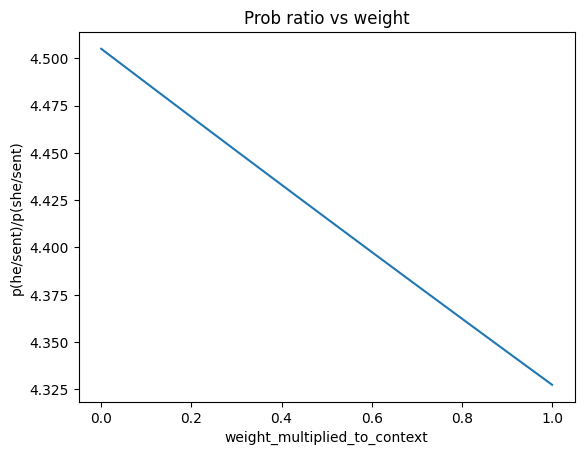

In [116]:
plt.plot(weight_list,prob_ratio_list)
plt.xlabel('weight_multiplied_to_context')
plt.ylabel('p(he/sent)/p(she/sent)')
plt.title('Prob ratio vs weight')
plt.show()